In [1]:
#pip install statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# AR - Autoregressive Model

## 1) Load the data - IMPORTANT: remainder.csv!

In [3]:
df = pd.read_csv('flights_remainder.csv', index_col=0, parse_dates=True)
df.head()

,remainder
date,
1949-01-01,4.405303
1949-02-01,17.496212
1949-03-01,7.496212
1949-04-01,9.587121
1949-05-01,-5.231061


In [4]:
# Plot the data
def plot_remainder(df, title='Remaining Passenger Number after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    plt.show()

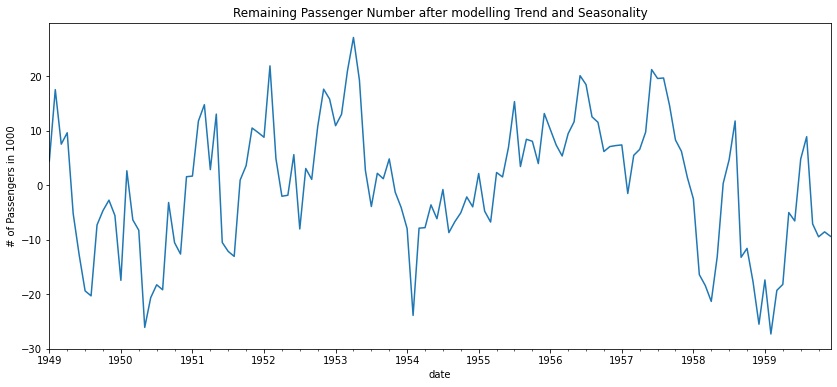

In [5]:
plot_remainder(df['remainder'])

## 2) Create a time-lagged input feature: lag1

A lag is an interval of time between two related phenomena. The two related phenomena in this case are the remainder today and the remainder tomorrow.

In [6]:
df['lag1'] = df['remainder'].shift(1)
df.head()

,remainder,lag1
date,,
1949-01-01,4.405303,NaN
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121


## 3) Inspect correlations

In [7]:
df.corr()

,remainder,lag1
remainder,1.000000,0.758226
lag1,0.758226,1.000000


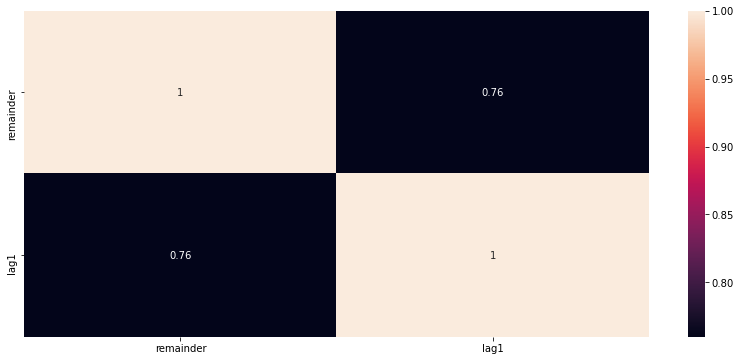

In [8]:
sns.heatmap(round(df.corr(), 2), annot=True)
plt.show()

#### Intuitively

- Flights data: If we observer more than usual (after taking into account trend and season) flights today we would expect to observe more than usual flights tomorrow.

- Temperature data: If it is warmer than usual today we would expect that it is warmer than usual tomorrow.

## 4) Plot remainder against lag1

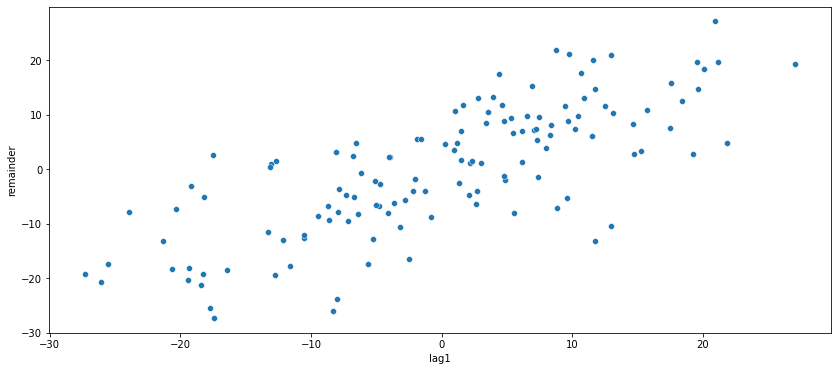

In [9]:
sns.scatterplot(x='lag1', y='remainder', data=df)
plt.show()

# AR - Autoregressive Model

Now we are ready to talk about the autoregressive model. In the autoregressive model we model the future value of a variable by looking at the present (and maybe past) value of the same variable. In our case the variable will be the **remainder**.

$$
y_{t+1} = w_0 + \sum_{j=0}^{P-1}w_{j}y_{t-j} + \epsilon_t
$$

where $t$ is the current timestep, $w_0$ is the bias/intercept, the w’s are the weights of the model and $\epsilon$ is some iid (e.g. Gaussian) noise. **P** is the number of lags used in the model. It is a hyperparameter that we have to choose.

**AR(1) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t}
$$

or in case of our remainder

$$
\hat{remainder_{t+1}} = w_0 + w_1 * remainder_{t}
$$

In an AR(1) model we model the value in $t+1$ as a linear function of the value in $t$.

**AR(2) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t} + w_2 * y_{t-1}
$$

# 5) Run an Autoregression (Linear Regression) of lag1 on the remainder

In [10]:
# Drop missing values
df.dropna(inplace=True)
df.head()

,remainder,lag1
date,,
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121
1949-06-01,-12.776515,-5.231061


In [11]:
# Assign X and y
y = df['remainder']
X = df[['lag1']]

In [12]:
# Create and fit the model with sklearn
model = LinearRegression()

In [13]:
model.fit(X, y)

LinearRegression()

In [14]:
# Create predictions
df['predictions_ar1'] = model.predict(X)

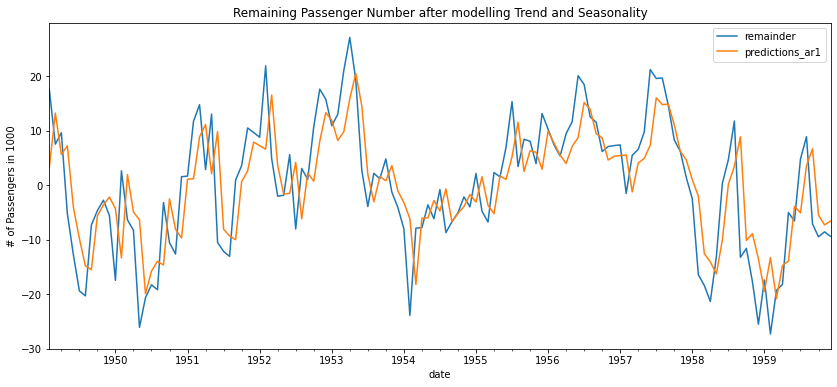

In [15]:
# Plot the original remainder and the prediction
plot_remainder(df[['remainder', 'predictions_ar1']])

In [16]:
# Create and plot the residual
df['residual'] = df['remainder'] - df['lag1']
df.head()

,remainder,lag1,predictions_ar1,residual
date,,,,
1949-02-01,17.496212,4.405303,3.258369,13.090909
1949-03-01,7.496212,17.496212,13.203025,-10.000000
1949-04-01,9.587121,7.496212,5.606413,2.090909
1949-05-01,-5.231061,9.587121,7.194795,-14.818182
1949-06-01,-12.776515,-5.231061,-4.062003,-7.545455


<AxesSubplot:xlabel='date'>

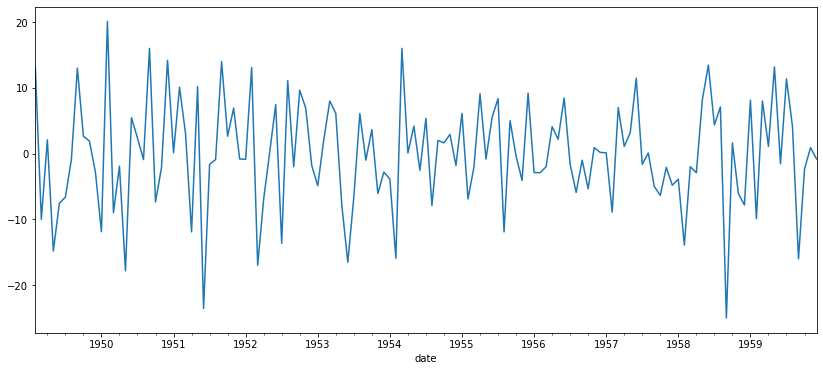

In [17]:
df['residual'].plot()

# 6) Should we add lag2?

How could we find out?

In [18]:
# Create second lag
df['lag2'] = df['remainder'].shift(2)
df.head()

,remainder,lag1,predictions_ar1,residual,lag2
date,,,,,
1949-02-01,17.496212,4.405303,3.258369,13.090909,NaN
1949-03-01,7.496212,17.496212,13.203025,-10.000000,NaN
1949-04-01,9.587121,7.496212,5.606413,2.090909,17.496212
1949-05-01,-5.231061,9.587121,7.194795,-14.818182,7.496212
1949-06-01,-12.776515,-5.231061,-4.062003,-7.545455,9.587121


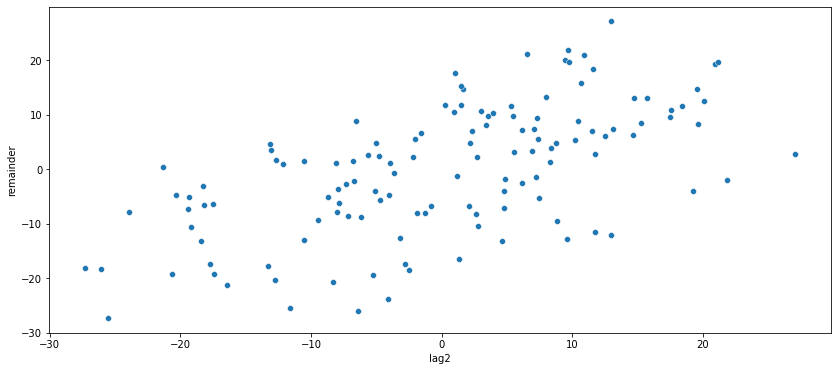

In [19]:
# Plot the remainder against the second lag
sns.scatterplot(x='lag2', y='remainder', data=df)
plt.show()

What do you think, should we include it?

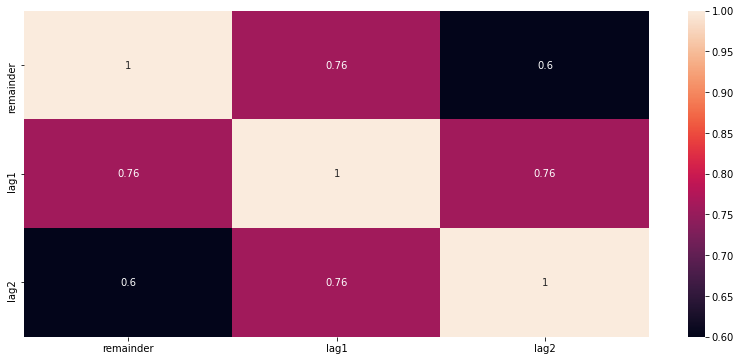

In [20]:
# Plot correlations again
sns.heatmap(round(df[['remainder', 'lag1', 'lag2']].corr(), 2), annot=True)
plt.show()

In [21]:
0.76*0.76

0.5776

Does the correlation seem high?

## 6.1) Partial Autocorrelation

One tool to find out how many lags we should include into our Autoregressive Model is to plot the Partial Autocorrelation between different lags. What is the Partial Autocorrelation?

$$
\delta_h = Corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

A measure of time dependence is the so-called partial-autocorrelation function (PACF), which is the correlation between $y_t$ and $y_{t−h}$, conditional on the intermediate values (eg. $y_{t-1}$, $y_{t-2}$, ..., $y_{t-h+1}$).

They are basically nothing else than the coefficients in a linear regression if you included h lags.

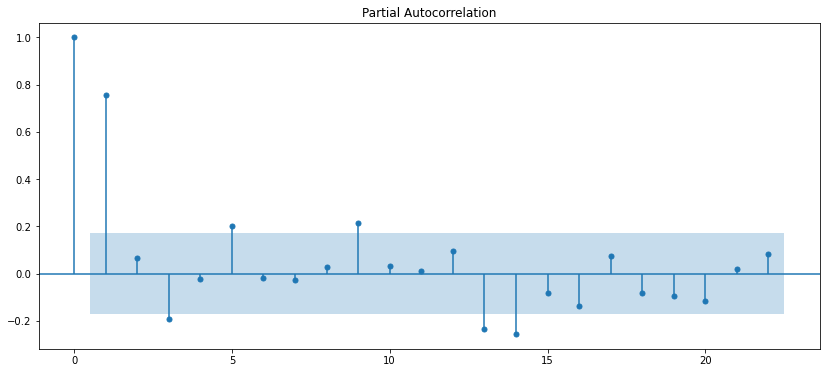

In [22]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf # plot partial autocorrelation function
plot_pacf(df['remainder']);

**Box-Jenkins-Methodology:**

This methodology makes a statement about how to choose lags.

We will choose all lags until the first sharp drop in values. In this case we will have 1 lag.

## 6.2) Introduce statsmodels and ar_select_order

In [23]:
# ar_select_order is from statsmodels

In [24]:
selected_order = ar_select_order(df['remainder'], maxlag=12)

/home/mmuratardag/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mmuratardag/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [25]:
# How many lags does ar_select_order 
selected_order.ar_lags

array([1])

In [26]:
selected_order.bic # bic stands for Bayesian Information Criterion and it is a metric that (kind of)
# is based on the probability of observing the data that you have, if it came from a certain model; eg. AR(1)

{(1,): 4.150951021392848,
 (1, 2): 4.183369450603206,
 (1, 2, 3): 4.196850880300978,
 (1, 2, 3, 4): 4.235078989622637,
 (1, 2, 3, 4, 5): 4.254817537966491,
 (1, 2, 3, 4, 5, 6): 4.294101886540034,
 (1, 2, 3, 4, 5, 6, 7): 4.334166077931185,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 4.3518273956416795,
 (1, 2, 3, 4, 5, 6, 7, 8): 4.371796908483157,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 4.390276974176126,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 4.4280452873345455,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 4.463615285511331,
 0: 4.975572610726659}

In [27]:
# statsmodels also has an AutoReg which does a bit of the modelling for you
# Only use this if you feel comfortable
model_sm = AutoReg(df['remainder'], lags=1).fit()

/home/mmuratardag/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [28]:
# Look at the model summary
df['predictions_sm'] = model_sm.predict()
df.head()

,remainder,lag1,predictions_ar1,residual,lag2,predictions_sm
date,,,,,,
1949-02-01,17.496212,4.405303,3.258369,13.090909,NaN,NaN
1949-03-01,7.496212,17.496212,13.203025,-10.000000,NaN,13.034350
1949-04-01,9.587121,7.496212,5.606413,2.090909,17.496212,5.471621
1949-05-01,-5.231061,9.587121,7.194795,-14.818182,7.496212,7.052919
1949-06-01,-12.776515,-5.231061,-4.062003,-7.545455,9.587121,-4.153670


# What now?

- This afternoon we completely focused on modelling the remainder separate from everything else.
- In the end we are still interested in the absolut number of passengers (or temperature), not in the remainder itself

Next step: Add the number of lags that your analysis left you off with to your DataFrame and create a new model with the features timestep, seasonal_dummies and the lags. This can be the lags of the original measure (temperature or passengers) or the lags of the remainder. Going forward it will be easier to include the lag of the original measure.